## Notebook to test the impact of a midatlantic ridge

In [1]:
import xarray as xr
import xgcm
from matplotlib import pyplot as plt
import nc_time_axis

#plt.rcParams['axes.facecolor']='black'
#plt.style.use('dark_background')
plt.style.use('default')

#plt.rcParams.update({'font.size': 20})

In [2]:
path   = "/data/dkamm/nemo_output/NEVERWORLD/"

## Load domain (not lazy)

In [3]:
from pathlib import Path
import xnemogcm as xn

In [4]:
datadir_gaus    = Path(path + 'GAUS_RIDGE_init/restart1')
datadir_no      = Path(path + 'NO_RIDGE_init/restart1')

In [5]:
domcfg_gaus = xn.open_domain_cfg(datadir=datadir_gaus)
domcfg_no   = xn.open_domain_cfg(datadir=datadir_no  )

### 1. Bathymetry without mid-atlantic ridge

In [ ]:
%matplotlib widget
fig = plt.figure()
ax  = plt.axes(projection='3d')
ax.set_box_aspect(aspect = (1,2.5,1))
p1 = (-domcfg_no.e3w_0.sum('z_f')).plot.surface(ax=ax)
ax.set_title('')

### 2. Bathymetry with mid-atlantic ridge:      Gaussian edge 

In [ ]:
%matplotlib widget
fig = plt.figure()
ax  = plt.axes(projection='3d')
ax.set_box_aspect(aspect = (1,2.5,1))
p2 = (-domcfg_gaus.e3w_0.sum('z_f')).plot.surface(ax=ax)
ax.set_title('')

In [ ]:
import numpy as np

def gauss(rn_slp, rn_edge_n, phi, h_top, h_bot):
    if(h_bot >= h_top):
        gauss = (h_top - h_bot) * np.exp( - ( ( phi - rn_edge_n ) / rn_slp ) ** 2 ) + h_bot
    else:
        gauss = h_bot
    return gauss

In [6]:
Data_no = xn.open_nemo(domcfg=domcfg_no, files=[
        datadir_no / '../restart7/NEVERWORLD_grid_T.nc',
        datadir_no / '../restart7/NEVERWORLD_grid_U.nc',
        datadir_no / '../restart7/NEVERWORLD_grid_V.nc'
    ])

Data_gaus = xn.open_nemo(domcfg=domcfg_gaus, files=[
        datadir_gaus / '../restart7/NEVERWORLD_grid_T.nc',
        datadir_gaus / '../restart7/NEVERWORLD_grid_U.nc',
        datadir_gaus / '../restart7/NEVERWORLD_grid_V.nc'
    ])

In [7]:
Data_no_mo = xn.open_nemo(domcfg=domcfg_no, files=[
        datadir_no / '../restart7/NEVERWORLD_grid_T_mo.nc'
    ])

Data_gaus_mo = xn.open_nemo(domcfg=domcfg_gaus, files=[
        datadir_gaus / '../restart7/NEVERWORLD_grid_T_mo.nc'
    ])

### Monthly averaged MLD

Text(0.5, 1.04, 'Monthly average over the last ten years: No Mid-Atlantic ridge')

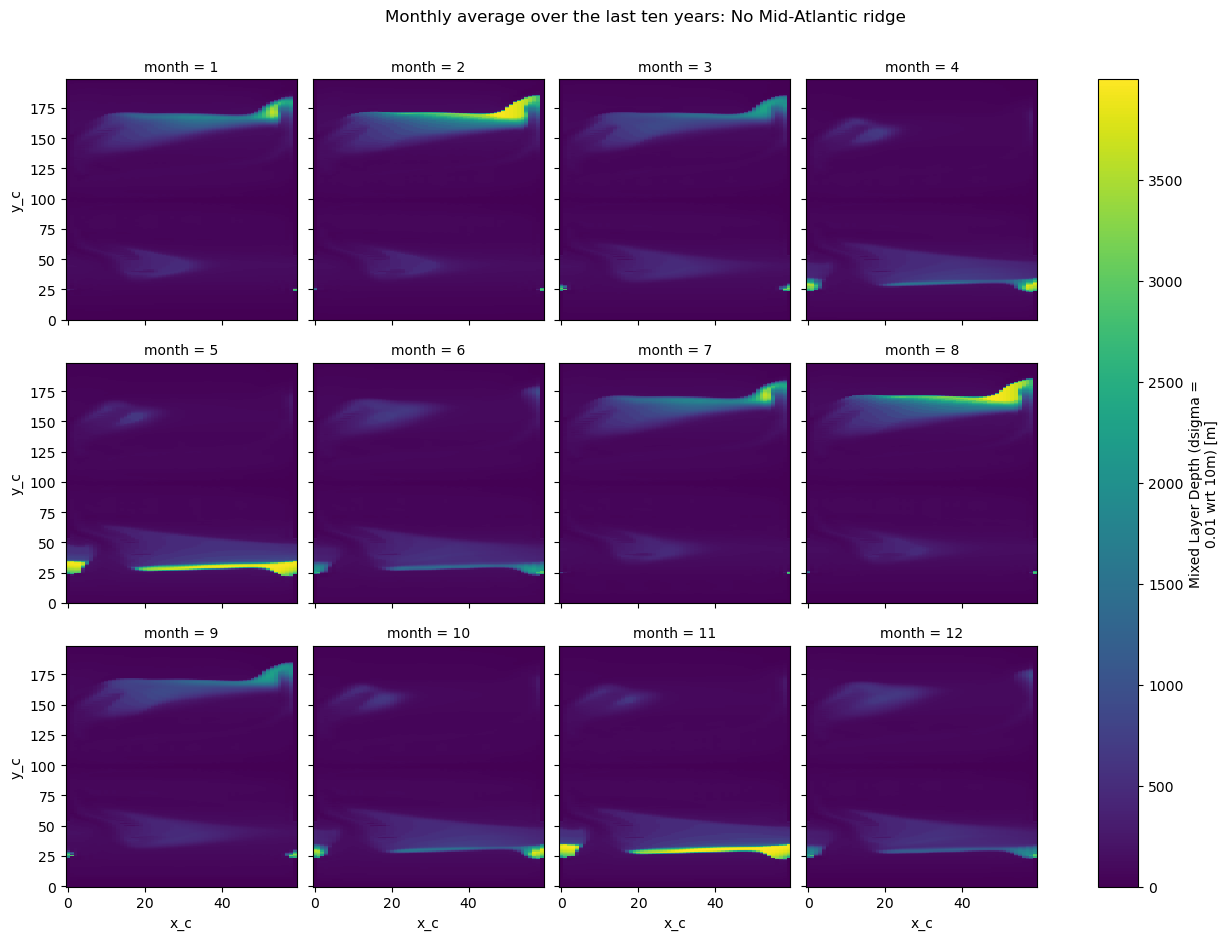

In [8]:
Data_no_mo.mldr10_1.isel(t=slice(-120,-1)).groupby("t.month").mean().plot(col='month', col_wrap=4)
plt.suptitle('Monthly average over the last ten years: No Mid-Atlantic ridge', y=1.04)

Text(0.5, 1.04, 'Monthly average over the last ten years: With Mid-Atlantic ridge')

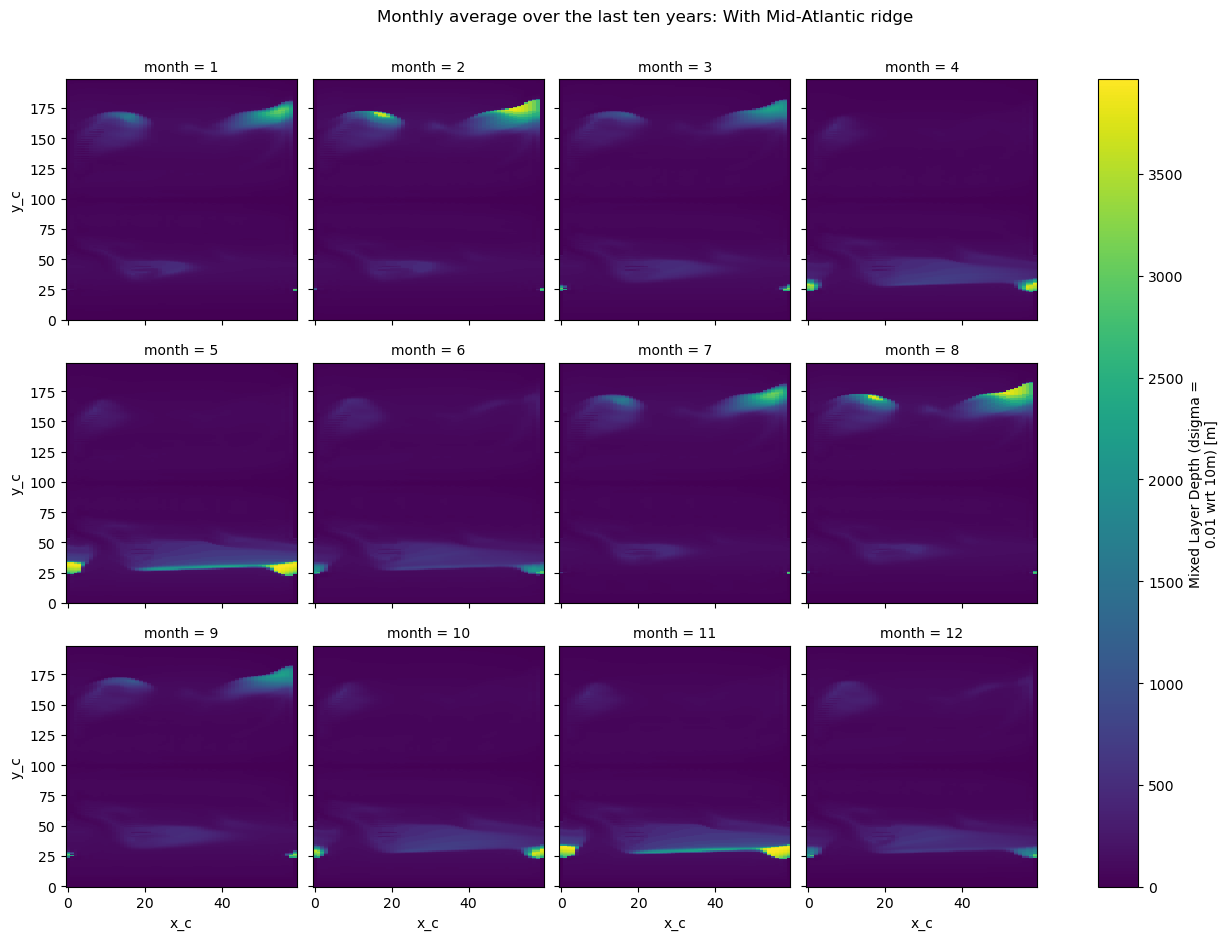

In [9]:
Data_gaus_mo.mldr10_1.isel(t=slice(-120,-1)).groupby("t.month").mean().plot(col='month', col_wrap=4)
plt.suptitle('Monthly average over the last ten years: With Mid-Atlantic ridge', y=1.04)

### Barotropic Streamfunction

In [10]:
metrics = {
    ('X',): ['e1t', 'e1u', 'e1v', 'e1f'], # X distances
    ('Y',): ['e2t', 'e2u', 'e2v', 'e2f'], # Y distances
    ('Z',): ['e3t_0', 'e3u_0', 'e3v_0', 'e3f_0'] # Z distances
}

grid_no = xgcm.Grid(domcfg_no,
        coords={
            "X": {"right": "x_f", "center": "x_c"},
            "Y": {"right": "y_f", "center":"y_c"},
            "Z": {"right": "z_f", "center": "z_c"}
        },
        periodic=False,
        metrics=metrics
)

grid_gaus = xgcm.Grid(domcfg_gaus,
        coords={
            "X": {"right": "x_f", "center": "x_c"},
            "Y": {"right": "y_f", "center":"y_c"},
            "Z": {"right": "z_f", "center": "z_c"}
        },
        periodic=False,
        metrics=metrics
)

In [11]:
#Interpolating on u_f
Data_no['u_f'] = grid_no.interp(Data_no.uoce, 'Y')
Data_gaus['u_f'] = grid_gaus.interp(Data_gaus.uoce, 'Y')

#Integrating over depth
Data_no['U'] = grid_no.integrate(Data_no.u_f, 'Z')
Data_gaus['U'] = grid_gaus.integrate(Data_gaus.u_f, 'Z')

#Cumulative integral over x
Psi_no = (Data_no.U[-1,::-1,:] * domcfg_no.e2f[::-1,:]).cumsum('y_f') / 1e6
Psi_gaus = (Data_gaus.U[-1,::-1,:] * domcfg_gaus.e2f[::-1,:]).cumsum('y_f') / 1e6

Text(0.5, 1.0, 'Without mid-atlantic ridge')

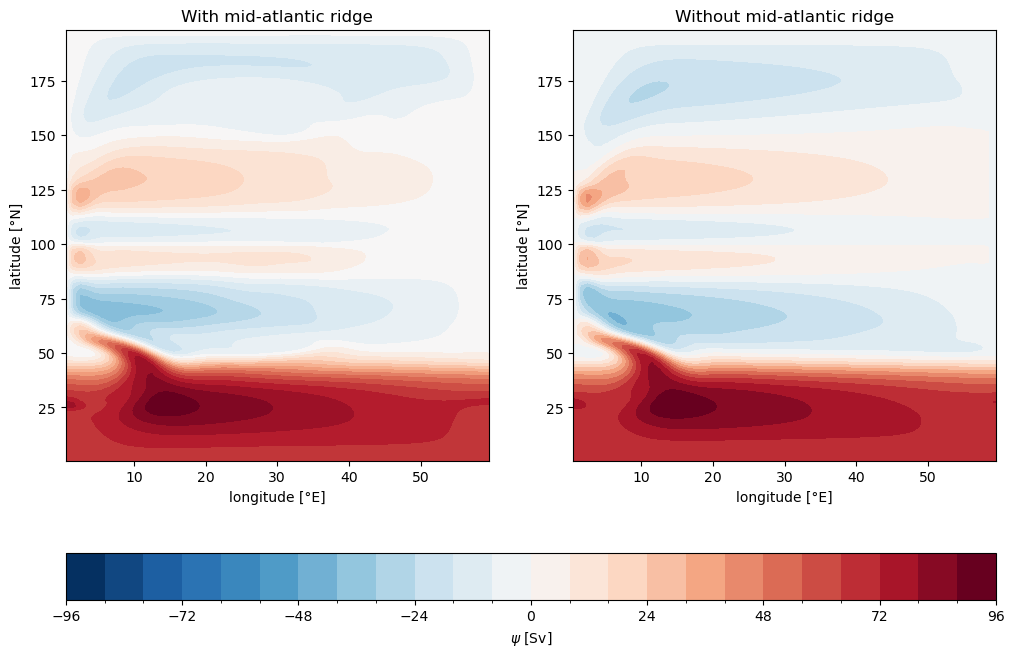

In [12]:
fig, axs = plt.subplots(1,2,figsize=(12,8))
a = Psi_no.plot.contourf(x='x_f', y='y_f', cmap='RdBu_r', levels=30, add_colorbar=False, ax=axs[1])
cbar1 = fig.colorbar(a, ax=axs[:2], location='bottom', label=r'$\psi$ [Sv]')
b = Psi_gaus.plot.contourf(x='x_f', y='y_f', cmap='RdBu_r', levels=30, add_colorbar=False, ax=axs[0], vmin=cbar1.vmin, vmax=cbar1.vmax)
axs[0].set_ylabel('latitude [°N]')
axs[1].set_ylabel('latitude [°N]')
axs[0].set_xlabel('longitude [°E]')
axs[1].set_xlabel('longitude [°E]')
axs[0].set_title('With mid-atlantic ridge')
axs[1].set_title('Without mid-atlantic ridge')

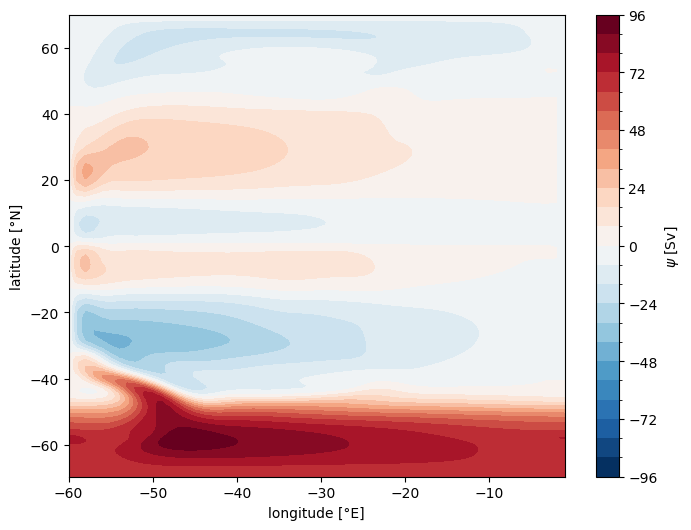

In [13]:
Psi_gaus = Psi_gaus.assign_coords(dict(
    x_sh=(["y_f", "x_f"], Psi_gaus.glamf.values - 60.)
    ))
fig, axs = plt.subplots(1,1,figsize=(8,6))
a = Psi_gaus.plot.contourf(x='x_sh', y='gphif', cmap='RdBu_r', levels=30, add_colorbar=False)
cbar1 = fig.colorbar(a, ax=axs, label=r'$\psi$ [Sv]')
axs.set_ylabel('latitude [°N]')
axs.set_xlabel('longitude [°E]')
plt.title('')
axs.set_facecolor('none')
fig.savefig('BSF.png', transparent=True)

### Cross-equatorial meridional velocities

In [15]:
Data_no = Data_no.assign_coords(dict(
    depthv=(["z_c", "y_f", "x_c"], - Data_no.isel(t=-1).e3v.cumsum('z_c').values)
    )
)

Data_gaus = Data_gaus.assign_coords(dict(
    depthv=(["z_c", "y_f", "x_c"], - Data_gaus.isel(t=-1).e3v.cumsum('z_c').values)
    )
)

Text(0.5, 1.0, 'Without mid-atlantic ridge')

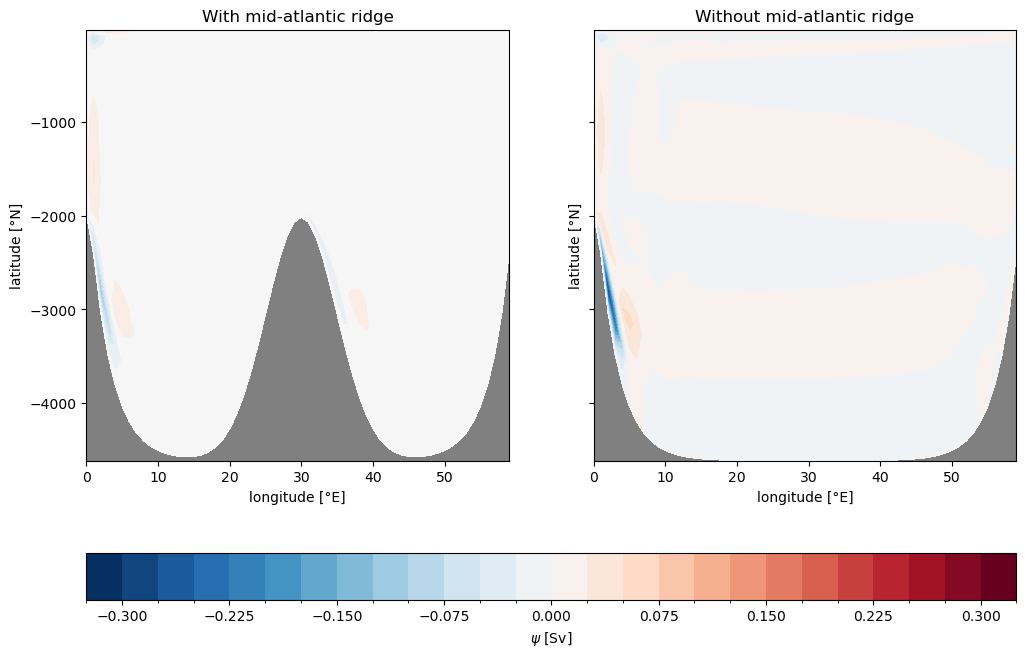

In [16]:
fig, axs = plt.subplots(1,2,figsize=(12,8), sharey=True)
a = (Data_no.vocetr_eff.isel(t=-1, y_f=100) / 10e6).plot.contourf(x='x_c', y='depthv', cmap='RdBu_r', levels=30, add_colorbar=False, ax=axs[1])
cbar1 = fig.colorbar(a, ax=axs[:2], location='bottom', label=r'$\psi$ [Sv]')
b = (Data_gaus.vocetr_eff.isel(t=-1, y_f=100) / 10e6).plot.contourf(x='x_c', y='depthv', cmap='RdBu_r', levels=30, add_colorbar=False, ax=axs[0], vmin=cbar1.vmin, vmax=cbar1.vmax)
axs[0].set_ylabel('latitude [°N]')
axs[1].set_ylabel('latitude [°N]')
axs[0].set_facecolor('grey')
axs[1].set_facecolor('grey')
axs[1].set_ylabel('latitude [°N]')
axs[0].set_xlabel('longitude [°E]')
axs[1].set_xlabel('longitude [°E]')
axs[0].set_title('With mid-atlantic ridge')
axs[1].set_title('Without mid-atlantic ridge')

In [ ]:
#!jupyter nbconvert --to html ./Mid_Atlantic_Ridge.ipynb --HTMLExporter.theme=dark 

## Meridional overturning

### Cutting the bottom cell and create a new grid object

In [17]:
import cf_xarray
import gsw

Data_no_cp = Data_no.isel(z_c=slice(0,-1)).copy()
Data_gaus_cp = Data_gaus.isel(z_c=slice(0,-1)).copy()

level_outer_no = cf_xarray.bounds_to_vertices(Data_no_cp.deptht_bounds, 'axis_nbounds').load().data
level_outer_gaus = cf_xarray.bounds_to_vertices(Data_gaus_cp.deptht_bounds, 'axis_nbounds').load().data

Data_no_cp = Data_no_cp.assign_coords({'z_f': level_outer_no})
Data_gaus_cp = Data_gaus_cp.assign_coords({'z_f': level_outer_gaus})

grid_no_cp = xgcm.Grid(Data_no_cp,
    coords={
        "X": {"center": "x_c"},
        "Y": {"right": "y_f", "center":"y_c"},
        "Z": {"center": "z_c", "outer": "z_f"}
    },
    periodic=False)

grid_gaus_cp = xgcm.Grid(Data_gaus_cp,
    coords={
        "X": {"center": "x_c"},
        "Y": {"right": "y_f", "center":"y_c"},
        "Z": {"center": "z_c", "outer": "z_f"}
    },
    periodic=False)

### Compute potential density, referenced to 2000m

In [18]:
Data_no_cp['sigma0'] = gsw.sigma0(Data_no_cp.soce, gsw.CT_from_pt(Data_no_cp.soce, Data_no_cp.toce))
Data_gaus_cp['sigma0'] = gsw.sigma0(Data_gaus_cp.soce, gsw.CT_from_pt(Data_gaus_cp.soce, Data_gaus_cp.toce))

### Interpolate sigma2 on the cell faces

In [19]:
sigma_v_no = grid_no_cp.interp(Data_no_cp.sigma0, 'Y')
sigma_outer_no = grid_no_cp.interp(sigma_v_no, 'Z',  boundary='extend')

sigma_v_gaus = grid_gaus_cp.interp(Data_gaus_cp.sigma0, 'Y')
sigma_outer_gaus = grid_gaus_cp.interp(sigma_v_gaus, 'Z',  boundary='extend')

### Target values for the new density coordinates

In [20]:
import numpy as np
sigma_target = np.array([24, 24.2, 24.4, 24.65, 24.9, 25.15, 25.4, 25.65,
                        25.9, 26.15, 26.4, 26.57, 26.75, 26.90, 27.05, 27.17,
                        27.30, 27.37, 27.45, 27.52, 27.58,
                        27.63, 27.68, 27.72, 27.75, 27.78, 27.80, 27.815,
                        27.83, 27.845, 27.86, 27.875, 27.89,
                        27.905, 27.92, 27.935, 27.95, 27.965,
                        27.98, 27.99, 28.01, 28.025,
                        28.04, 28.055, 28.07, 28.085, 28.1, 28.35,
                        28.6, 28.8, 29.1])

### Transforming the meridional transport on density coordinates

In [21]:
vtra_no = grid_no_cp.transform(Data_no_cp.vocetr_eff,
        'Z',
        sigma_target,
        method='conservative',
        target_data=sigma_outer_no)

vtra_gaus = grid_gaus_cp.transform(Data_gaus_cp.vocetr_eff,
        'Z',
        sigma_target,
        method='conservative',
        target_data=sigma_outer_gaus)

/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  out = xr.apply_ufunc(
/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/home/dkamm/miniconda3/envs/nemo_env/lib/python3.9/site-packages/xgcm/transform.py:247: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_

### Computing the meridional overturning

In [22]:
Over_no    = vtra_no.isel(t=-1).sum(dim='x_c')[:,::-1].cumsum('sigma0') / 1e6
Over_gaus    = vtra_gaus.isel(t=-1).sum(dim='x_c')[:,::-1].cumsum('sigma0') / 1e6

In [23]:
Over_no = Over_no.assign_coords(dict({'y_f': domcfg_no.gphif.isel(x_f=10).values}))
Over_gaus = Over_gaus.assign_coords(dict({'y_f': domcfg_gaus.gphif.isel(x_f=10).values}))

Text(0.5, 1.0, 'No Mid-Atlantic Ridge')

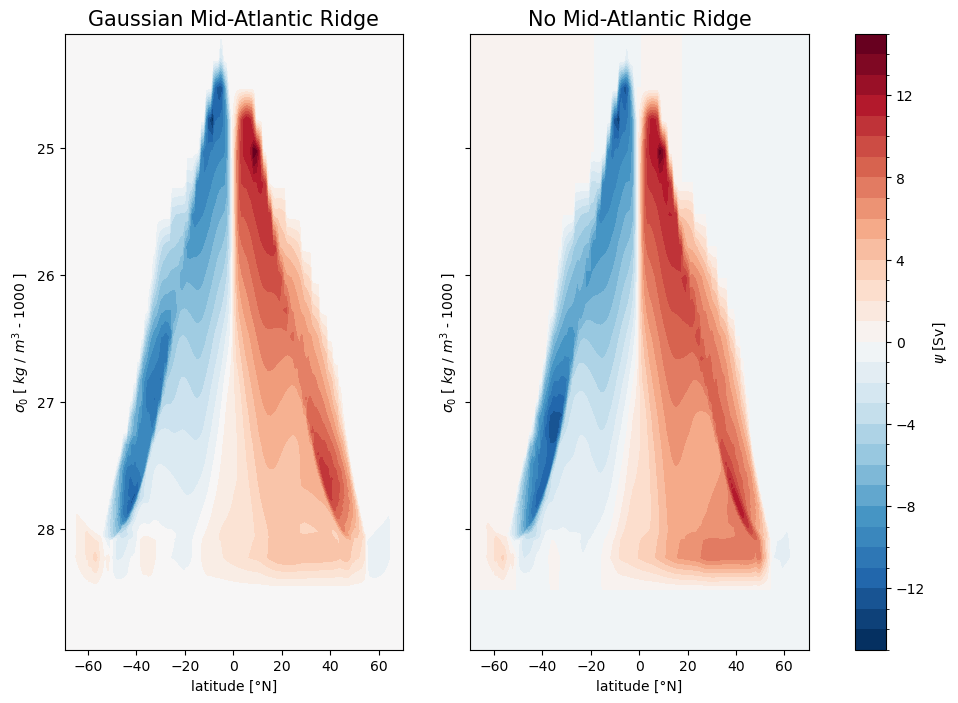

In [25]:
fig, axs = plt.subplots(1,2,figsize=(12,8), sharey=True)
a = (-Over_no).plot.contourf(x='y_f', y='sigma0', cmap='RdBu_r', levels=30, add_colorbar=False, ax=axs[1])
cbar1 = fig.colorbar(a, ax=axs, label=r'$\psi$ [Sv]')
b = (-Over_gaus).plot.contourf(x='y_f', y='sigma0', cmap='RdBu_r', levels=30, add_colorbar=False, ax=axs[0], vmin=cbar1.vmin, vmax=cbar1.vmax)
axs[0].invert_yaxis()
axs[0].set_ylabel(r'$\sigma_{0}$ [ $kg$ / $m^3$ - 1000 ]')
axs[1].set_ylabel(r'$\sigma_{0}$ [ $kg$ / $m^3$ - 1000 ]')
axs[0].set_xlabel('latitude [°N]')
axs[1].set_xlabel('latitude [°N]')
axs[0].set_title('Gaussian Mid-Atlantic Ridge', fontsize=15)
axs[1].set_title('No Mid-Atlantic Ridge', fontsize=15)

### ACC strength

In [ ]:
n_restarts = 8

In [ ]:
#Combine restart files
for i in range(n_restarts-2, 0, -1):
    _datadir = Path(path + 'NO_RIDGE_init/restart{}/'.format(i))
    _Data = xn.open_nemo(domcfg=domcfg_no, files=[
        _datadir / 'NEVERWORLD_grid_T.nc',
        _datadir / 'NEVERWORLD_grid_U.nc',
        _datadir / 'NEVERWORLD_grid_V.nc'
    ])
    Data_no = xr.concat([_Data.chunk(), Data_no.chunk()], "t")

for i in range(n_restarts-2, 0, -1):
    _datadir = Path(path + 'GAUS_RIDGE_init/restart{}/'.format(i))
    _Data = xn.open_nemo(domcfg=domcfg_gaus, files=[
        _datadir / 'NEVERWORLD_grid_T.nc',
        _datadir / 'NEVERWORLD_grid_U.nc',
        _datadir / 'NEVERWORLD_grid_V.nc'
    ])
    Data_gaus = xr.concat([_Data.chunk(), Data_gaus.chunk()], "t")

In [ ]:
#Compute ACC transport
ACC_no = Data_no.isel(x_f=0).uocetr_eff.sum(['y_c', 'z_c']) / 1e6
ACC_gaus = Data_gaus.isel(x_f=0).uocetr_eff.sum(['y_c', 'z_c']) / 1e6

#OR!!!!
#ACC_no = (Data_no.isel(x_f=0).uoce * Data_no.isel(x_f=0).e2u * Data_no.isel(x_f=0).e3u).sum(['y_c', 'z_c']) / 1e6

In [ ]:
import cftime as cft
ACC_no = ACC_no.assign_coords(dict({'t':cft.to_tuple(ACC_no.indexes['t'])[0]}))
ACC_gaus = ACC_gaus.assign_coords(dict({'t':cft.to_tuple(ACC_gaus.indexes['t'])[0]}))

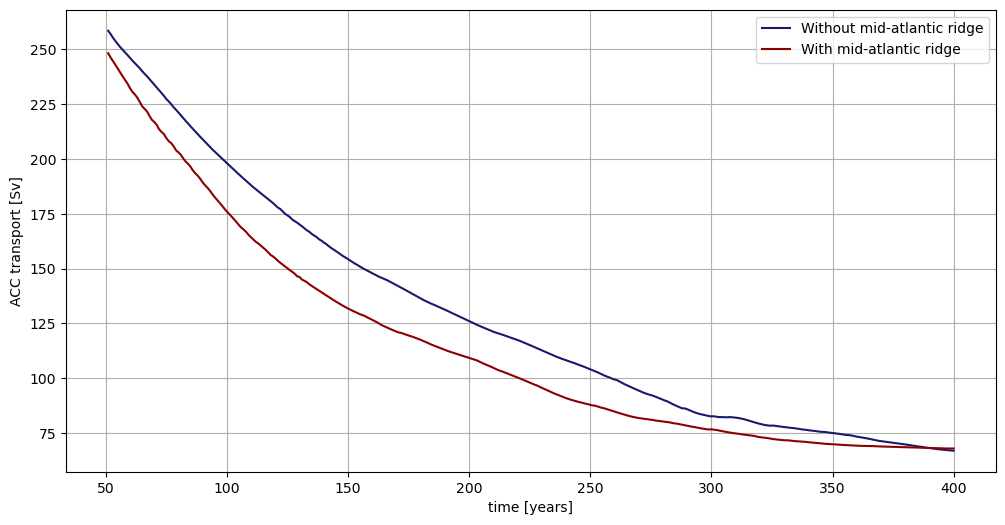

In [ ]:
fig, axs = plt.subplots(1,1, figsize=(12,6))
ACC_no.plot(color='midnightblue', label='Without mid-atlantic ridge')
ACC_gaus.plot(color='darkred', label='With mid-atlantic ridge')
axs.set_ylabel('ACC transport [Sv]')
plt.title('')
plt.xlabel('time [years]')
plt.legend()
plt.grid()